In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import glob
from scipy.stats import entropy, ks_2samp
from sklearn.model_selection import ParameterGrid
import random
from imblearn.combine import SMOTEENN
import os
import scikitplot as skplt
import seaborn as sns
import dtreeviz 
from collections import Counter 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
os.chdir('/data/chamal/projects/mila/2021_fMRI_dev/part2_phgy_fmri_project/5_analysis/decision_tree')

In [3]:
import decision_tree_functions

# DR 2-min window tree (only the zscored input phgy)

In [4]:
#load csv
dr_phgy_df = pd.read_csv('/data/chamal/projects/mila/2021_fMRI_dev/part2_phgy_fmri_project/5_analysis/DR_analysis-to_extract_network_detectability/final_outputs/master_DR_and_phgy_variableWindow_sparse.csv')

# add a column that essentially binarizes network detectability into pass and fail
dr_phgy_df['Somatomotor or DMN network detected'] = (np.abs(dr_phgy_df['Average correlation to network'])>=0.45) 

#properly encode the variables as numbers (sklearn doesn't handle categorical)
dr_phgy_df['strain'] = dr_phgy_df['strain'].map({'C57Bl/6':1, 'C3HeB/FeJ':2})
dr_phgy_df['sex'] = dr_phgy_df['sex'].map({'m':1, 'f':2})

indices_high_iso = dr_phgy_df[dr_phgy_df['Iso percent'] == 1.5].index


In [5]:
percent_positive_windows = dr_phgy_df['Somatomotor or DMN network detected'].sum()/len(dr_phgy_df['Somatomotor or DMN network detected'])
print(f'{percent_positive_windows} of train data is positive (contains network)')

0.46637744034707157 of train data is positive (contains network)


In [6]:
#select the independent and physiological variables from the full df.
df = dr_phgy_df[['actual_ses_order', 'strain', 'sex', 
       'Time after isoflurane change',
       'Mean FD- mean in window', 'Max FD- mean in window',
       'RR-sexstrain_zscore- mean in window',
       'RRV-sexstrain_zscore- mean in window',
       'RV-sexstrain_zscore- mean in window',
       'HR-sexstrain_zscore- mean in window',
       'HRV- mean in window',
       'PVI- mean in window',
       'SpO2-sexstrain_zscore- mean in window',
       'Somatomotor or DMN network detected', 'Iso percent', 'dex_conc']]
df_for_subset_characteristics = dr_phgy_df[['epi_filename', 'Start Time Realtime', 'actual_ses_order', 'strain', 'sex', 'session_ID', 'age_days',
                                          'Time after isoflurane change',
                                            'Mean FD- mean in window', 'Max FD- mean in window',
                                            'RR-sexstrain_zscore- mean in window',
                                            'RRV-sexstrain_zscore- mean in window',
                                            'RV-sexstrain_zscore- mean in window',
                                            'HR-sexstrain_zscore- mean in window',
                                            'HRV- mean in window',
                                            'PVI- mean in window',
                                            'SpO2-sexstrain_zscore- mean in window',
                                          'Somatomotor or DMN network detected', 'Iso percent', 'dex_conc']]

df = df.rename(columns = {'actual_ses_order': 'session order (correlated to age)',
                            'Iso percent': 'isoflurane (%)',
                            'dex_conc': 'dexmedetomidine (mg/kg/h)',
                            'RR-sexstrain_zscore- mean in window': 'RR (zscored by strain/sex)',
                        'RRV-sexstrain_zscore- mean in window': 'RRV (zscored by strain/sex)',
                        'RV-sexstrain_zscore- mean in window': 'RV (zscored by strain/sex)',
                        'HR-sexstrain_zscore- mean in window': 'HR (zscored by strain/sex)',
                        'HRV- mean in window': 'HRV', 
                        'PVI- mean in window': 'PVI ',
                        'SpO2-sexstrain_zscore- mean in window': 'SpO2 (zscored by strain/sex)',
                        'Mean FD- mean in window': 'Mean FD',
                          'Max FD- mean in window': 'Max FD'})
df_for_subset_characteristics = df_for_subset_characteristics.rename(columns = {'actual_ses_order': 'session order (correlated to age)',
                            'Iso percent': 'isoflurane (%)', 'age_days': 'age (days)',
                            'dex_conc': 'dexmedetomidine (mg/kg/h)',
                            'RR-sexstrain_zscore- mean in window': 'RR (zscored by strain/sex)',
                        'RRV-sexstrain_zscore- mean in window': 'RRV (zscored by strain/sex)',
                        'RV-sexstrain_zscore- mean in window': 'RV (zscored by strain/sex)',
                        'HR-sexstrain_zscore- mean in window': 'HR (zscored by strain/sex)',
                        'HRV- mean in window': 'HRV', 
                        'PVI- mean in window': 'PVI ',
                        'SpO2-sexstrain_zscore- mean in window': 'SpO2 (zscored by strain/sex)',
                        'Mean FD- mean in window': 'Mean FD',
                          'Max FD- mean in window': 'Max FD'})
variable_to_predict = "Somatomotor or DMN network detected"

In [7]:
X=df.drop(columns=[variable_to_predict])
Y=df[variable_to_predict]
X_train, X_test, Y_train, Y_test = decision_tree_functions.custom_stratified_train_test_split_with_group(X, Y, predetermined_test_groups=(1, 9, 12, 15, 25, 28, 31, 35, 42, 43), group = dr_phgy_df['session_ID'],   random_state = 1)

#drop the windows with very high iso 1.5% because they are very rare
X_train = X_train.drop(indices_high_iso, errors = 'ignore')
X_test = X_test.drop(indices_high_iso, errors = 'ignore')
Y_train = Y_train.drop(indices_high_iso, errors = 'ignore')
Y_test = Y_test.drop(indices_high_iso, errors = 'ignore')


Groups in test set: (1, 9, 12, 15, 25, 28, 31, 35, 42, 43)
Groups in train set: [ 2  3  5  6  8 10 11 13 14 16 18 19 20 22 23 26 27 29 30 32 33 34 36 37
 38 39 40 44 45 46 47]


### Hyperparameter tuning

In [8]:
hyperparameter_dict = {"tree_depth": [2,3,4],
                       "splitter": ["random", "best"],
                       "max_leaf_nodes": ["None", "2xdepth"]}
grid = list(ParameterGrid(hyperparameter_dict))
print(f'There are {len(grid)} combinations to test')

There are 12 combinations to test


In [9]:
for params in grid:

    #extract the parameters from the dict
    tree_depth = params['tree_depth']
    splitter_type = params['splitter']
    if params['max_leaf_nodes'] == 'None':
        max_leaves = None
    elif params['max_leaf_nodes'] == '2xdepth':
        max_leaves = params['tree_depth']*2

    # we want to include at least 20 samples per leaf (small leaves are not useful)
    min_samples_leaf_value = 20

    #train the model
    tree_def= DecisionTreeClassifier(criterion = 'gini', random_state=1255, 
                                            max_depth = tree_depth, min_samples_leaf=min_samples_leaf_value, 
                                            splitter = splitter_type,
                                            max_leaf_nodes=max_leaves) 
    model = tree_def.fit(X_train, Y_train)

    #plot the tree
    viz_model = dtreeviz.model(tree_def, 
                    X_train=X_train,
                    y_train=Y_train,
                    target_name='Network present?',
                    feature_names=X_train.columns.to_list(),
                    class_names=['False', 'True'])
    v = viz_model.view()     # render as SVG into internal object 
    basename = f'./hyperparameter_tuning_outputs/zscored_phgy-{tree_depth}-depth_{min_samples_leaf_value}-leaf_{splitter_type}_{max_leaves}-leaves'
    v.save(f'{basename}_tree.svg')

    #apply it to test data
    y_hat = tree_def.predict(X_test)
    y_probas = tree_def.predict_proba(X_test)

    #quantify performance on test data
    print(basename)
    print( sklearn.metrics.classification_report(Y_test, y_hat))
    
    #output confusion matrix
    sns.set(rc={'figure.figsize':(4,4)})
    skplt.metrics.plot_confusion_matrix(Y_test, y_hat, normalize=True)
    plt.tight_layout()
    plt.savefig(f'{basename}_normalized_confusion.png')
    plt.close()


/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_phgy-2-depth_20-leaf_random_None-leaves
              precision    recall  f1-score   support

       False       0.75      0.60      0.67        50
        True       0.72      0.84      0.78        62

    accuracy                           0.73       112
   macro avg       0.74      0.72      0.72       112
weighted avg       0.73      0.73      0.73       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_phgy-3-depth_20-leaf_random_None-leaves
              precision    recall  f1-score   support

       False       0.75      0.82      0.78        50
        True       0.84      0.77      0.81        62

    accuracy                           0.79       112
   macro avg       0.79      0.80      0.79       112
weighted avg       0.80      0.79      0.80       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_phgy-4-depth_20-leaf_random_None-leaves
              precision    recall  f1-score   support

       False       0.70      0.90      0.79        50
        True       0.90      0.69      0.78        62

    accuracy                           0.79       112
   macro avg       0.80      0.80      0.79       112
weighted avg       0.81      0.79      0.79       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_phgy-2-depth_20-leaf_best_None-leaves
              precision    recall  f1-score   support

       False       0.72      0.52      0.60        50
        True       0.68      0.84      0.75        62

    accuracy                           0.70       112
   macro avg       0.70      0.68      0.68       112
weighted avg       0.70      0.70      0.69       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_phgy-3-depth_20-leaf_best_None-leaves
              precision    recall  f1-score   support

       False       0.76      0.84      0.80        50
        True       0.86      0.79      0.82        62

    accuracy                           0.81       112
   macro avg       0.81      0.82      0.81       112
weighted avg       0.82      0.81      0.81       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_phgy-4-depth_20-leaf_best_None-leaves
              precision    recall  f1-score   support

       False       0.72      0.68      0.70        50
        True       0.75      0.79      0.77        62

    accuracy                           0.74       112
   macro avg       0.74      0.74      0.74       112
weighted avg       0.74      0.74      0.74       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_phgy-2-depth_20-leaf_random_4-leaves
              precision    recall  f1-score   support

       False       0.75      0.60      0.67        50
        True       0.72      0.84      0.78        62

    accuracy                           0.73       112
   macro avg       0.74      0.72      0.72       112
weighted avg       0.73      0.73      0.73       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_phgy-3-depth_20-leaf_random_6-leaves
              precision    recall  f1-score   support

       False       0.70      0.90      0.79        50
        True       0.90      0.69      0.78        62

    accuracy                           0.79       112
   macro avg       0.80      0.80      0.79       112
weighted avg       0.81      0.79      0.79       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_phgy-4-depth_20-leaf_random_8-leaves
              precision    recall  f1-score   support

       False       0.70      0.90      0.79        50
        True       0.90      0.69      0.78        62

    accuracy                           0.79       112
   macro avg       0.80      0.80      0.79       112
weighted avg       0.81      0.79      0.79       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_phgy-2-depth_20-leaf_best_4-leaves
              precision    recall  f1-score   support

       False       0.72      0.52      0.60        50
        True       0.68      0.84      0.75        62

    accuracy                           0.70       112
   macro avg       0.70      0.68      0.68       112
weighted avg       0.70      0.70      0.69       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_phgy-3-depth_20-leaf_best_6-leaves
              precision    recall  f1-score   support

       False       0.76      0.84      0.80        50
        True       0.86      0.79      0.82        62

    accuracy                           0.81       112
   macro avg       0.81      0.82      0.81       112
weighted avg       0.82      0.81      0.81       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_phgy-4-depth_20-leaf_best_8-leaves
              precision    recall  f1-score   support

       False       0.72      0.68      0.70        50
        True       0.75      0.79      0.77        62

    accuracy                           0.74       112
   macro avg       0.74      0.74      0.74       112
weighted avg       0.74      0.74      0.74       112



### Final tree

/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


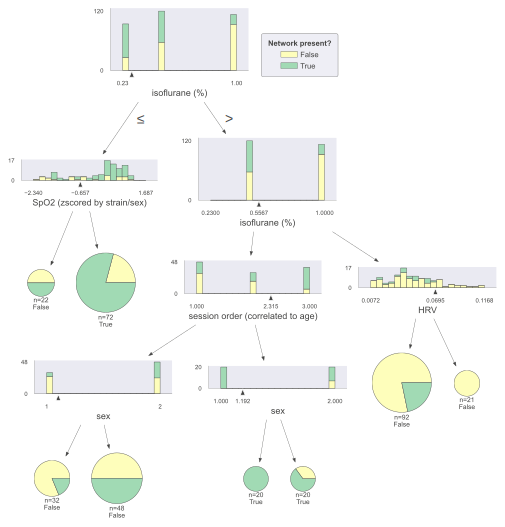

In [10]:
tree_depth = 4
gini_decrease_value = 0.00
min_samples_leaf_value = 20
splitter_type = 'random'
max_leaves = tree_depth*2

tree_def= DecisionTreeClassifier(criterion = 'gini', random_state=1255, min_impurity_decrease= gini_decrease_value,
                                        max_depth = tree_depth, min_samples_leaf=min_samples_leaf_value, splitter = splitter_type,
                                        max_leaf_nodes=max_leaves) 
model = tree_def.fit(X_train, Y_train)

viz_model = dtreeviz.model(tree_def, 
                X_train=X_train,
                y_train=Y_train,
                target_name='Network present?',
                feature_names=X_train.columns.to_list(),
                class_names=['False', 'True'])
v = viz_model.view()     # render as SVG into internal object 
basename = f'./final_paper_plots/zscored_phgy-{tree_depth}-depth_{min_samples_leaf_value}-leaf_{splitter_type}_{max_leaves}-leaves'
v.save(f'{basename}_tree.svg')
v

In [11]:
text_representation = tree.export_text(model, decimals = 8, feature_names=X_train.columns.to_list(), class_names=['False', 'True'])
print(text_representation)

|--- isoflurane (%) <= 0.29210226
|   |--- SpO2 (zscored by strain/sex) <= -0.65736049
|   |   |--- class: False
|   |--- SpO2 (zscored by strain/sex) >  -0.65736049
|   |   |--- class: True
|--- isoflurane (%) >  0.29210226
|   |--- isoflurane (%) <= 0.55668690
|   |   |--- session order (correlated to age) <= 2.31511344
|   |   |   |--- sex <= 1.10266974
|   |   |   |   |--- class: False
|   |   |   |--- sex >  1.10266974
|   |   |   |   |--- class: False
|   |   |--- session order (correlated to age) >  2.31511344
|   |   |   |--- sex <= 1.19169456
|   |   |   |   |--- class: True
|   |   |   |--- sex >  1.19169456
|   |   |   |   |--- class: True
|   |--- isoflurane (%) >  0.55668690
|   |   |--- HRV <= 0.06953519
|   |   |   |--- class: False
|   |   |--- HRV >  0.06953519
|   |   |   |--- class: False



              precision    recall  f1-score   support

       False       0.70      0.90      0.79        50
        True       0.90      0.69      0.78        62

    accuracy                           0.79       112
   macro avg       0.80      0.80      0.79       112
weighted avg       0.81      0.79      0.79       112



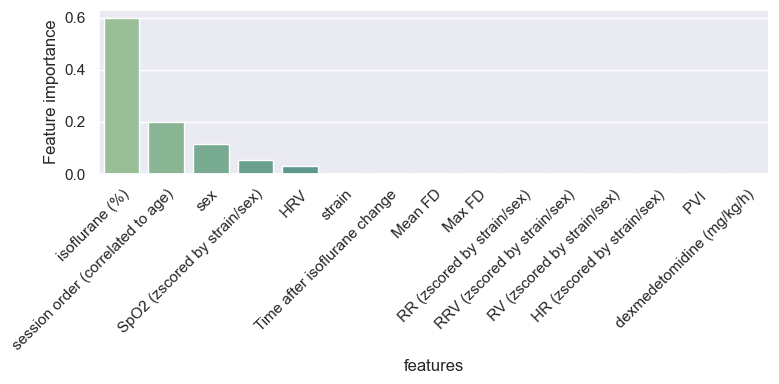

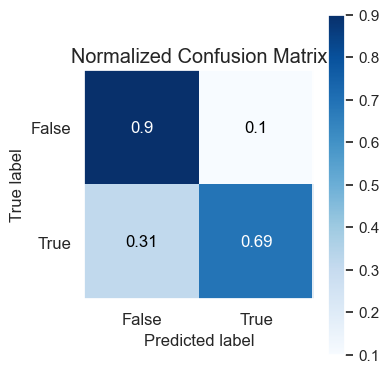

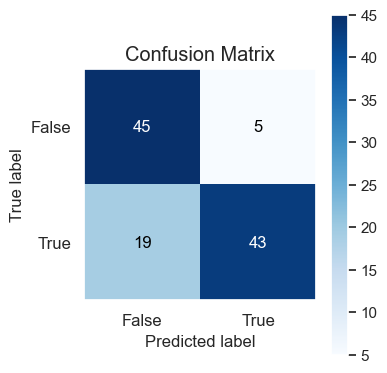

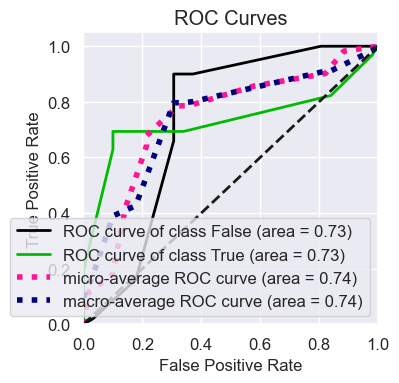

In [12]:
y_hat = tree_def.predict(X_test)
y_probas = tree_def.predict_proba(X_test)
print( sklearn.metrics.classification_report(Y_test, y_hat))

#output feature importance
feature_importance=pd.DataFrame({'Feature importance':tree_def.feature_importances_, 'features': X_train.columns})
feature_importance.sort_values(by  = 'Feature importance', ascending=False,inplace=True)
sns.set(rc={'figure.figsize':(8,4)})
fig3 = sns.barplot(feature_importance, x = 'features', y = 'Feature importance', orient = 'v', palette='crest').get_figure()
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
fig3.savefig(f'{basename}_feature_importance.svg')

sns.set(rc={'figure.figsize':(4,4)})
skplt.metrics.plot_confusion_matrix(Y_test, y_hat, normalize=True)
plt.tight_layout()
plt.savefig(f'{basename}_normalized_confusion.png')

skplt.metrics.plot_confusion_matrix(Y_test, y_hat)
plt.tight_layout()
plt.savefig(f'{basename}_confusion.png')

fig1 = skplt.metrics.plot_roc(Y_test, y_probas)
plt.tight_layout()
plt.savefig(f'{basename}_roc_curve.png')

### extract scans in the ideal (realistic subset)

In [13]:
ideal_subset_selector = (df_for_subset_characteristics['isoflurane (%)'] == 0.23) & (df_for_subset_characteristics['SpO2 (zscored by strain/sex)']>-0.65736049)
ideal_subset_df = df_for_subset_characteristics[ideal_subset_selector]
ideal_subset_df.to_csv("./dt_subset_csvs/dt_phgy_idealSubset_VERYLOWISO_HIGHSPO2.csv")

alt_subset_selector = (df_for_subset_characteristics['isoflurane (%)'] == 0.23) & (df_for_subset_characteristics['SpO2 (zscored by strain/sex)']<=-0.65736049)
alt_subset_df = df_for_subset_characteristics[alt_subset_selector]
ideal_subset_df.to_csv("./dt_subset_csvs/dt_phgy_altsubset_VERYLOWISO_LOWSPO2.csv")

rest_subset_selector = (df_for_subset_characteristics['isoflurane (%)'] > 0.23)
rest_subset_df = df_for_subset_characteristics[rest_subset_selector]
ideal_subset_df.to_csv("./dt_subset_csvs/dt_phgy_other.csv")

In [14]:
print(f' out of {len(ideal_subset_df)} windows within the ideal subset, {len(ideal_subset_df[ideal_subset_df["Somatomotor or DMN network detected"] == True])} contained the network (train + test)')

 out of 104 windows within the ideal subset, 84 contained the network (train + test)


In [15]:
#after manual inspection, there are some scans that were partially/mostly part of the subset (but some windows excluded)
#so we want to check if they fell into the other subset or whether they were just never included in the original df (e.g. due to censoring earlier on)
dict_possibly_excluded_scans = {"scan1": {"filename": 'sub-PHG002_ses-2', "window": 0.0},
                                "scan2": {"filename": 'sub-PHG002_ses-3', "window": 0.0},
                                "scan3": {"filename": 'sub-PHG014_ses-3', "window": 0.0},
                                "scan4": {"filename": 'sub-PHG014_ses-3', "window": 120.0},
                                "scan5": {"filename": 'sub-PHG014_ses-3', "window": 240.0},
                                "scan6": {"filename": 'sub-PHG016_ses-1', "window": 0.0},
                                "scan7": {"filename": 'sub-PHG016_ses-1', "window": 120.0},
                                "scan8": {"filename": 'sub-PHG016_ses-1', "window": 360.0}}
for possibly_excluded_window in dict_possibly_excluded_scans.keys():
    originally_in_df = df_for_subset_characteristics[(df_for_subset_characteristics['epi_filename'] == dict_possibly_excluded_scans[possibly_excluded_window]["filename"]) & (df_for_subset_characteristics['Start Time Realtime'] == dict_possibly_excluded_scans[possibly_excluded_window]["window"])]
    if len(originally_in_df)==0:
        excluded = False
    else:
        excluded = True
    print(f'scan {dict_possibly_excluded_scans[possibly_excluded_window]["filename"]} at window time {dict_possibly_excluded_scans[possibly_excluded_window]["window"]} fell into the alternative spo2 subset: {excluded}')

scan sub-PHG002_ses-2 at window time 0.0 fell into the alternative spo2 subset: False
scan sub-PHG002_ses-3 at window time 0.0 fell into the alternative spo2 subset: False
scan sub-PHG014_ses-3 at window time 0.0 fell into the alternative spo2 subset: True
scan sub-PHG014_ses-3 at window time 120.0 fell into the alternative spo2 subset: True
scan sub-PHG014_ses-3 at window time 240.0 fell into the alternative spo2 subset: True
scan sub-PHG016_ses-1 at window time 0.0 fell into the alternative spo2 subset: True
scan sub-PHG016_ses-1 at window time 120.0 fell into the alternative spo2 subset: True
scan sub-PHG016_ses-1 at window time 360.0 fell into the alternative spo2 subset: True


In [16]:
#put together a scan list of all the scans in the subset, but exclude sub-PHG014_ses-3 and sub-PHG016_ses-1 since the majority of that scan fell into the other subset
ideal_subset_df.loc[:, "epi_filename_full"] = ideal_subset_df["epi_filename"] + '_task-rest_acq-EPI_run-1_bold'
ideal_subset_scanlist_reindex = ideal_subset_df.set_index("epi_filename_full")
ideal_subset_windowlist = ideal_subset_scanlist_reindex.drop(['sub-PHG014_ses-3_task-rest_acq-EPI_run-1_bold', 'sub-PHG016_ses-1_task-rest_acq-EPI_run-1_bold'])
ideal_subset_scanlist = ideal_subset_windowlist.index.drop_duplicates()
ideal_subset_scanlist

/tmp/user/1182/ipykernel_3614137/2790382780.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Index(['sub-PHG001_ses-1_task-rest_acq-EPI_run-1_bold',
       'sub-PHG001_ses-3_task-rest_acq-EPI_run-1_bold',
       'sub-PHG002_ses-2_task-rest_acq-EPI_run-1_bold',
       'sub-PHG002_ses-3_task-rest_acq-EPI_run-1_bold',
       'sub-PHG003_ses-1_task-rest_acq-EPI_run-1_bold',
       'sub-PHG003_ses-2_task-rest_acq-EPI_run-1_bold',
       'sub-PHG004_ses-3_task-rest_acq-EPI_run-1_bold',
       'sub-PHG006_ses-1_task-rest_acq-EPI_run-1_bold',
       'sub-PHG006_ses-3_task-rest_acq-EPI_run-1_bold',
       'sub-PHG008_ses-3_task-rest_acq-EPI_run-1_bold',
       'sub-PHG009_ses-3_task-rest_acq-EPI_run-1_bold',
       'sub-PHG010_ses-2_task-rest_acq-EPI_run-1_bold',
       'sub-PHG011_ses-1_task-rest_acq-EPI_run-1_bold',
       'sub-PHG011_ses-2_task-rest_acq-EPI_run-1_bold',
       'sub-PHG011_ses-3_task-rest_acq-EPI_run-1_bold',
       'sub-PHG012_ses-1_task-rest_acq-EPI_run-1_bold',
       'sub-PHG012_ses-2_task-rest_acq-EPI_run-1_bold',
       'sub-PHG012_ses-3_task-rest_acq-EPI_run-1

In [17]:
#lets also get the scans in the alternate subset (ultralowiso and low spo2)
alt_subset_df.loc[:, "epi_filename_full"] = alt_subset_df["epi_filename"] + '_task-rest_acq-EPI_run-1_bold'
alt_subset_scanlist_reindex = alt_subset_df.set_index("epi_filename_full")
alt_subset_scanlist = alt_subset_scanlist_reindex.index.drop_duplicates()
alt_subset_scanlist

/tmp/user/1182/ipykernel_3614137/1871263890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Index(['sub-PHG002_ses-1_task-rest_acq-EPI_run-1_bold',
       'sub-PHG007_ses-2_task-rest_acq-EPI_run-1_bold',
       'sub-PHG009_ses-1_task-rest_acq-EPI_run-1_bold',
       'sub-PHG010_ses-1_task-rest_acq-EPI_run-1_bold',
       'sub-PHG013_ses-1_task-rest_acq-EPI_run-1_bold',
       'sub-PHG014_ses-3_task-rest_acq-EPI_run-1_bold',
       'sub-PHG016_ses-1_task-rest_acq-EPI_run-1_bold'],
      dtype='object', name='epi_filename_full')

summary: I have 26 scans out of 33 acquired at low iso (that did not get censored). There were 46 scans in total in the rabies ultralowiso QC csv, so 13 scans got removed somehow... These include 001_ses2 (pulseox qc), 003_ses3 (low iso was 0.5), 004_ses1 (pulseox qc), 004_ses2 (lowest iso was 0.5), 005_ses1 (lowest iso was 0.5), 005_ses2 (pulseox qc), 005_ses3 (lowest iso was 0.5), 007_ses1 (resp qc), 007_ses3 (lowest iso was 0.5), 008_ses1 (resp qc), 008_ses2 (lowest iso was 0.5), 010_ses3 (phgy qc), 013_ses2 (lowest iso was 0.5.)

In [18]:
# load the RABIES QC metrics for the low iso condition (0.23%) - these are not within 2-min time windows anymore but represent the whole 8 min at 0.23%
rabies_ultralowiso_qc_metrics_somat_df = pd.read_csv('../../4_derivatives/rabies_runs/local_data_final_runs/rabies_out_analysis-v050_05smoothed_lowpass_0-480/data_diagnosis_datasink/analysis_QC/analysis_QC/sample_distributions/DR0_outlier_detection.csv')
rabies_ultralowiso_qc_metrics_dmn_df = pd.read_csv('../../4_derivatives/rabies_runs/local_data_final_runs/rabies_out_analysis-v050_05smoothed_lowpass_0-480/data_diagnosis_datasink/analysis_QC/analysis_QC/sample_distributions/DR2_outlier_detection.csv')

rabies_midiso_qc_metrics_somat_df = pd.read_csv('../../4_derivatives/rabies_runs/local_data_final_runs/rabies_out_analysis-v050_05smoothed_lowpass_480-960/data_diagnosis_datasink/analysis_QC/analysis_QC/sample_distributions/DR0_outlier_detection.csv')
rabies_midiso_qc_metrics_dmn_df = pd.read_csv('../../4_derivatives/rabies_runs/local_data_final_runs/rabies_out_analysis-v050_05smoothed_lowpass_480-960/data_diagnosis_datasink/analysis_QC/analysis_QC/sample_distributions/DR2_outlier_detection.csv')

rabies_highiso_qc_metrics_somat_df = pd.read_csv('../../4_derivatives/rabies_runs/local_data_final_runs/rabies_out_analysis-v050_05smoothed_lowpass_960-1440/data_diagnosis_datasink/analysis_QC/analysis_QC/sample_distributions/DR0_outlier_detection.csv')
rabies_highiso_qc_metrics_dmn_df = pd.read_csv('../../4_derivatives/rabies_runs/local_data_final_runs/rabies_out_analysis-v050_05smoothed_lowpass_960-1440/data_diagnosis_datasink/analysis_QC/analysis_QC/sample_distributions/DR2_outlier_detection.csv')


In [19]:
# reset index to be the scan id
rabies_ultralowiso_qc_metrics_somat_df_reindex = rabies_ultralowiso_qc_metrics_somat_df.set_index("scan ID")

#create a column that indicates which subset each scan is in
conditions_somat = [
    rabies_ultralowiso_qc_metrics_somat_df_reindex.index.isin(ideal_subset_scanlist),
    rabies_ultralowiso_qc_metrics_somat_df_reindex.index.isin(alt_subset_scanlist)]
outcome_label = choices = ['Iso 0.23, high spo2 (ideal)', 'Iso 0.23, low spo2']
rabies_ultralowiso_qc_metrics_somat_df_reindex['Subset'] = np.select(conditions_somat, outcome_label, default='other')

#repeat for the other network
rabies_ultralowiso_qc_metrics_dmn_df_reindex = rabies_ultralowiso_qc_metrics_dmn_df.set_index("scan ID")
conditions_dmn = [
    rabies_ultralowiso_qc_metrics_dmn_df_reindex.index.isin(ideal_subset_scanlist),
    rabies_ultralowiso_qc_metrics_dmn_df_reindex.index.isin(alt_subset_scanlist)]
rabies_ultralowiso_qc_metrics_dmn_df_reindex['Subset'] = np.select(conditions_dmn, outcome_label, default='other')

In [20]:
#now also add the dfs from the later timepoints, in the subset 'other'
rabies_midiso_qc_metrics_somat_df['Subset'] = 'other'
rabies_midiso_qc_metrics_dmn_df['Subset'] = 'other'
rabies_highiso_qc_metrics_somat_df['Subset'] = 'other'
rabies_highiso_qc_metrics_dmn_df['Subset'] = 'other'

final_subset_qc_comparison_df_somat1 = pd.concat([rabies_ultralowiso_qc_metrics_somat_df_reindex, rabies_midiso_qc_metrics_somat_df, rabies_highiso_qc_metrics_somat_df])
final_subset_qc_comparison_df_dmn1 = pd.concat([rabies_ultralowiso_qc_metrics_dmn_df_reindex, rabies_midiso_qc_metrics_dmn_df, rabies_highiso_qc_metrics_dmn_df])

final_subset_qc_comparison_df_somat1['Network'] = 'Somatomotor'
final_subset_qc_comparison_df_dmn1['Network'] = 'DMN-like'

final_subset_qc_comparison_df1 = pd.concat([final_subset_qc_comparison_df_somat1, final_subset_qc_comparison_df_dmn1])

#order the final dataframe so that the ones in the ideal subset are at the top
order_priority = ['other', 'Iso 0.23, low spo2', 'Iso 0.23, high spo2 (ideal)'] 
final_subset_qc_comparison_df = final_subset_qc_comparison_df1.sort_values(
    by="Subset",
    key=lambda col: col.map({k: i for i, k in enumerate(order_priority)})
)


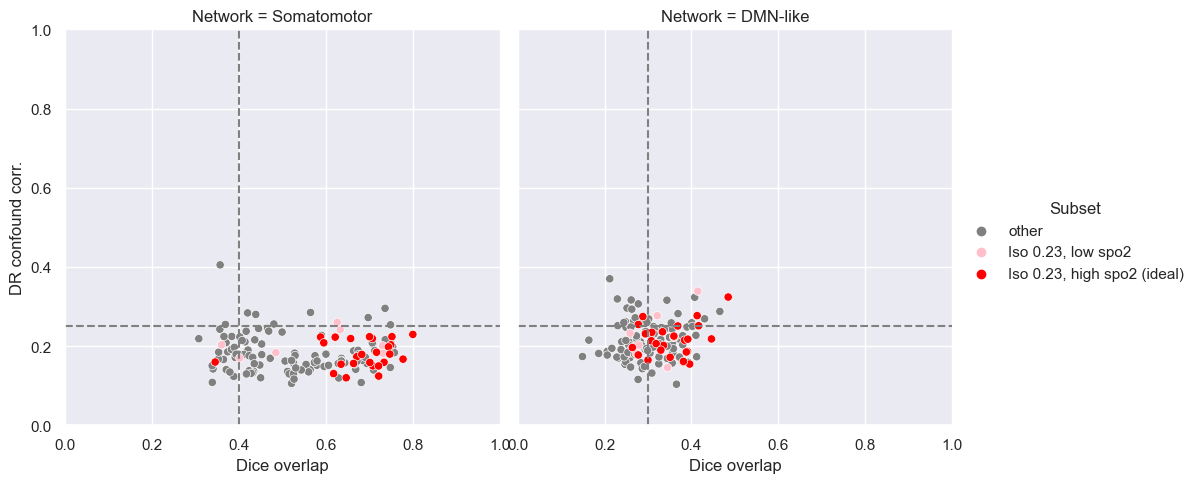

In [21]:
custom_palette = {
    "other": "gray",
    "Iso 0.23, low spo2": "pink",
    "Iso 0.23, high spo2 (ideal)":"red"
}
g=sns.relplot(final_subset_qc_comparison_df, x = "Dice overlap", y = "DR confound corr.", hue = 'Subset', col = "Network", palette = custom_palette)
linepos = [0.4, 0.3]
i=0
for ax in g.axes.flat:
    ax.axvline(x=linepos[i], color='gray', linestyle='--')  
    ax.axhline(y=0.25, color='gray', linestyle='--')  
    i = i+1

plt.xlim([0,1])
plt.ylim([0,1])
plt.savefig('./final_paper_plots/rabies_qc_8-min_in_DT_subsets.svg')
final_subset_qc_comparison_df.to_csv('./dt_subset_csvs/dt_phgy_rabies_qc_outputs_allscans_classified_by_subset.csv')

# DR 2-min window tree with zscored CPP inputs

In [22]:
#load csv
dr_phgy_df = pd.read_csv('/data/chamal/projects/mila/2021_fMRI_dev/part2_phgy_fmri_project/5_analysis/DR_analysis-to_extract_network_detectability/final_outputs/master_DR_and_phgy_variableWindow_sparse.csv')

# add a column that essentially binarizes network detectability into pass and fail
dr_phgy_df['Somatomotor or DMN network detected'] = (np.abs(dr_phgy_df['Average correlation to network'])>=0.45) 

#encode categorical variables as numbers (sklearn doesn't handle categories)
dr_phgy_df['strain'] = dr_phgy_df['strain'].map({'C57Bl/6':1, 'C3HeB/FeJ':2})
dr_phgy_df['sex'] = dr_phgy_df['sex'].map({'m':1, 'f':2})

indices_high_iso = dr_phgy_df[dr_phgy_df['Iso percent'] == 1.5].index


In [23]:
percent_positive_windows = dr_phgy_df['Somatomotor or DMN network detected'].sum()/len(dr_phgy_df['Somatomotor or DMN network detected'])
print(f'{percent_positive_windows} of train data is positive (contains network)')

0.46637744034707157 of train data is positive (contains network)


In [24]:
#drop the columns that I don't want to be used as features (don't use weight because hard to know whats driving low vs high weight)
# unlike in the linear models, I can use mean FD and max FD even if they are collinear here

df = dr_phgy_df[['actual_ses_order', 'strain', 'sex', 
       'Time after isoflurane change',
       'Mean FD- mean in window', 'Max FD- mean in window',
        'Somatomotor or DMN network detected', 'Iso percent', 'dex_conc',
        'CPP0 frequency (sexstrain zscore)',
        'CPP1 frequency (sexstrain zscore)',
        'CPP2 frequency (sexstrain zscore)',
        'CPP3 frequency (sexstrain zscore)',
        'CPP4 frequency (sexstrain zscore)']]

#rename columns
df = df.rename(columns = {'actual_ses_order': 'session order (correlated to age)',
                            'Iso percent': 'isoflurane (%)',
                            'dex_conc': 'dexmedetomidine (mg/kg/h)',
                            'CPP0 frequency (sexstrain zscore)': 'state0 frequency (sexstrain zscore)',
                            'CPP1 frequency (sexstrain zscore)': 'state1 frequency (sexstrain zscore)',
                            'CPP2 frequency (sexstrain zscore)': 'state2 frequency (sexstrain zscore)',
                            'CPP3 frequency (sexstrain zscore)': 'state3 frequency (sexstrain zscore)',
                            'CPP4 frequency (sexstrain zscore)': 'state4 frequency (sexstrain zscore)'})
variable_to_predict = "Somatomotor or DMN network detected"


In [25]:
# separate into train and test datasets using the same train/test split derived during the physiology zscoring
X=df.drop(columns=[variable_to_predict])
Y=df[variable_to_predict]
X_train, X_test, Y_train, Y_test = decision_tree_functions.custom_stratified_train_test_split_with_group(X, Y, predetermined_test_groups=(1, 9, 12, 15, 25, 28, 31, 35, 42, 43), group = dr_phgy_df['session_ID'],   random_state = 1)


Groups in test set: (1, 9, 12, 15, 25, 28, 31, 35, 42, 43)
Groups in train set: [ 2  3  5  6  8 10 11 13 14 16 18 19 20 22 23 26 27 29 30 32 33 34 36 37
 38 39 40 44 45 46 47]


In [26]:
#drop the windows with very high iso of 1.5% because they are rare 
# note this has to be done after the train test split otherwise I will have trouble using the same split as before
X_train = X_train.drop(indices_high_iso, errors = 'ignore')
X_test = X_test.drop(indices_high_iso, errors = 'ignore')
Y_train = Y_train.drop(indices_high_iso, errors = 'ignore')
Y_test = Y_test.drop(indices_high_iso, errors = 'ignore')

print('Train test split: ' + str(len(Y_train))  + ', ' + str(len(Y_test)))
print("Number of positives in training data: "  + str( np.sum(Y_train)))
print("NUmber of positives in test data: " + str(np.sum(Y_test)))
print("Size of test data: " + str(len(Y_test)))

Train test split: 327, 112
Number of positives in training data: 151
NUmber of positives in test data: 62
Size of test data: 112


### Hyperparameter tuning

In [27]:
hyperparameter_dict = {"tree_depth": [2,3,4],
                       "splitter": ["random", "best"],
                       "max_leaf_nodes": ["None", "2xdepth"]}
grid = list(ParameterGrid(hyperparameter_dict))
print(f'There are {len(grid)} combinations to test')

There are 12 combinations to test


In [28]:
for params in grid:

    #extract the parameters from the dict
    tree_depth = params['tree_depth']
    splitter_type = params['splitter']
    if params['max_leaf_nodes'] == 'None':
        max_leaves = None
    elif params['max_leaf_nodes'] == '2xdepth':
        max_leaves = params['tree_depth']*2

    # we want to include at least 20 samples per leaf (small leaves are not useful)
    min_samples_leaf_value = 20

    #train the model
    tree_def= DecisionTreeClassifier(criterion = 'gini', random_state=1255, 
                                            max_depth = tree_depth, min_samples_leaf=min_samples_leaf_value, 
                                            splitter = splitter_type,
                                            max_leaf_nodes=max_leaves) 
    model = tree_def.fit(X_train, Y_train)

    #plot the tree
    viz_model = dtreeviz.model(tree_def, 
                    X_train=X_train,
                    y_train=Y_train,
                    target_name='Network present?',
                    feature_names=X_train.columns.to_list(),
                    class_names=['False', 'True'])
    v = viz_model.view()     # render as SVG into internal object 
    basename = f'./hyperparameter_tuning_outputs/zscored_CPP-{tree_depth}-depth_{min_samples_leaf_value}-leaf_{splitter_type}_{max_leaves}-leaves'
    v.save(f'{basename}_tree.svg')

    #apply it to test data
    y_hat = tree_def.predict(X_test)
    y_probas = tree_def.predict_proba(X_test)

    #quantify performance on test data
    print(basename)
    print( sklearn.metrics.classification_report(Y_test, y_hat))
    
    #output confusion matrix
    sns.set(rc={'figure.figsize':(4,4)})
    skplt.metrics.plot_confusion_matrix(Y_test, y_hat, normalize=True)
    plt.tight_layout()
    plt.savefig(f'{basename}_normalized_confusion.png')
    plt.close()


/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_CPP-2-depth_20-leaf_random_None-leaves
              precision    recall  f1-score   support

       False       0.66      0.90      0.76        50
        True       0.89      0.63      0.74        62

    accuracy                           0.75       112
   macro avg       0.77      0.76      0.75       112
weighted avg       0.79      0.75      0.75       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_CPP-3-depth_20-leaf_random_None-leaves
              precision    recall  f1-score   support

       False       0.71      0.74      0.73        50
        True       0.78      0.76      0.77        62

    accuracy                           0.75       112
   macro avg       0.75      0.75      0.75       112
weighted avg       0.75      0.75      0.75       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_CPP-4-depth_20-leaf_random_None-leaves
              precision    recall  f1-score   support

       False       0.58      0.76      0.66        50
        True       0.74      0.56      0.64        62

    accuracy                           0.65       112
   macro avg       0.66      0.66      0.65       112
weighted avg       0.67      0.65      0.65       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_CPP-2-depth_20-leaf_best_None-leaves
              precision    recall  f1-score   support

       False       0.67      0.70      0.69        50
        True       0.75      0.73      0.74        62

    accuracy                           0.71       112
   macro avg       0.71      0.71      0.71       112
weighted avg       0.72      0.71      0.71       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_CPP-3-depth_20-leaf_best_None-leaves
              precision    recall  f1-score   support

       False       0.72      0.52      0.60        50
        True       0.68      0.84      0.75        62

    accuracy                           0.70       112
   macro avg       0.70      0.68      0.68       112
weighted avg       0.70      0.70      0.69       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_CPP-4-depth_20-leaf_best_None-leaves
              precision    recall  f1-score   support

       False       0.62      0.82      0.71        50
        True       0.80      0.60      0.69        62

    accuracy                           0.70       112
   macro avg       0.71      0.71      0.70       112
weighted avg       0.72      0.70      0.69       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_CPP-2-depth_20-leaf_random_4-leaves
              precision    recall  f1-score   support

       False       0.66      0.90      0.76        50
        True       0.89      0.63      0.74        62

    accuracy                           0.75       112
   macro avg       0.77      0.76      0.75       112
weighted avg       0.79      0.75      0.75       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_CPP-3-depth_20-leaf_random_6-leaves
              precision    recall  f1-score   support

       False       0.71      0.74      0.73        50
        True       0.78      0.76      0.77        62

    accuracy                           0.75       112
   macro avg       0.75      0.75      0.75       112
weighted avg       0.75      0.75      0.75       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_CPP-4-depth_20-leaf_random_8-leaves
              precision    recall  f1-score   support

       False       0.62      0.74      0.67        50
        True       0.75      0.63      0.68        62

    accuracy                           0.68       112
   macro avg       0.68      0.68      0.68       112
weighted avg       0.69      0.68      0.68       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_CPP-2-depth_20-leaf_best_4-leaves
              precision    recall  f1-score   support

       False       0.67      0.70      0.69        50
        True       0.75      0.73      0.74        62

    accuracy                           0.71       112
   macro avg       0.71      0.71      0.71       112
weighted avg       0.72      0.71      0.71       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_CPP-3-depth_20-leaf_best_6-leaves
              precision    recall  f1-score   support

       False       0.72      0.52      0.60        50
        True       0.68      0.84      0.75        62

    accuracy                           0.70       112
   macro avg       0.70      0.68      0.68       112
weighted avg       0.70      0.70      0.69       112



/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


./hyperparameter_tuning_outputs/zscored_CPP-4-depth_20-leaf_best_8-leaves
              precision    recall  f1-score   support

       False       0.62      0.82      0.71        50
        True       0.80      0.60      0.69        62

    accuracy                           0.70       112
   macro avg       0.71      0.71      0.70       112
weighted avg       0.72      0.70      0.69       112



### final tree

/home/cic/uromil/.conda/envs/decisionTree/lib/python3.11/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


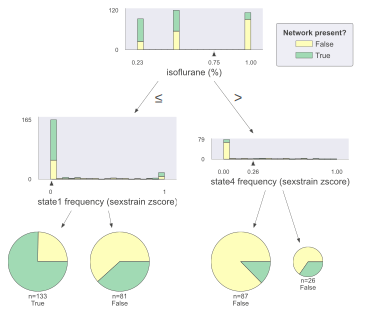

In [29]:
tree_depth = 2
gini_decrease_value = 0.00
min_samples_leaf_value = 20
splitter_type = 'best'
max_leaves = tree_depth*2

tree_def= DecisionTreeClassifier(criterion = 'gini', random_state=1255, min_impurity_decrease= gini_decrease_value,
                                        max_depth = tree_depth, min_samples_leaf=min_samples_leaf_value, splitter = splitter_type,
                                        max_leaf_nodes=max_leaves) 
model = tree_def.fit(X_train, Y_train)

viz_model = dtreeviz.model(tree_def, 
                X_train=X_train,
                y_train=Y_train,
                target_name='Network present?',
                feature_names=X_train.columns.to_list(),
                class_names=['False', 'True'])
v = viz_model.view()     # render as SVG into internal object 
basename = f'./final_paper_plots/zscored_CPP-{tree_depth}-depth_{min_samples_leaf_value}-leaf_{splitter_type}_{max_leaves}-leaves'
v.save(f'{basename}_tree.svg')
v

In [30]:
text_representation = tree.export_text(model, decimals = 8, feature_names=X_train.columns.to_list(), class_names=['False', 'True'])
print(text_representation)

|--- isoflurane (%) <= 0.75000000
|   |--- state1 frequency (sexstrain zscore) <= 0.00851079
|   |   |--- class: True
|   |--- state1 frequency (sexstrain zscore) >  0.00851079
|   |   |--- class: False
|--- isoflurane (%) >  0.75000000
|   |--- state4 frequency (sexstrain zscore) <= 0.26089057
|   |   |--- class: False
|   |--- state4 frequency (sexstrain zscore) >  0.26089057
|   |   |--- class: False



              precision    recall  f1-score   support

       False       0.67      0.70      0.69        50
        True       0.75      0.73      0.74        62

    accuracy                           0.71       112
   macro avg       0.71      0.71      0.71       112
weighted avg       0.72      0.71      0.71       112



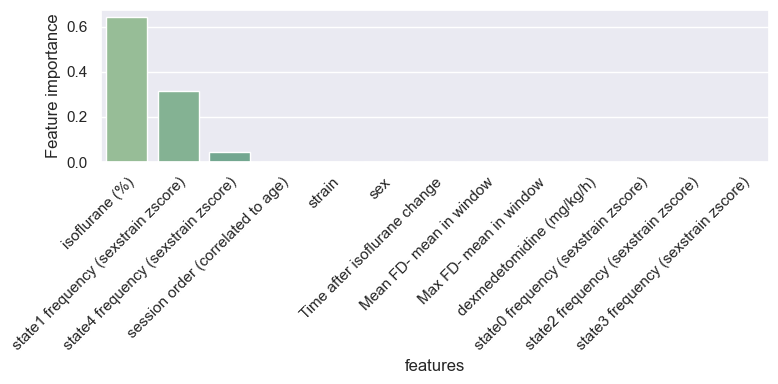

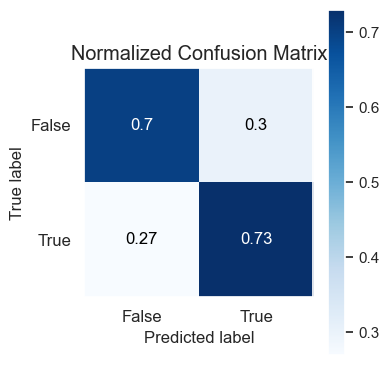

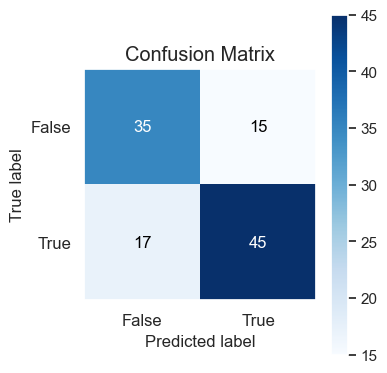

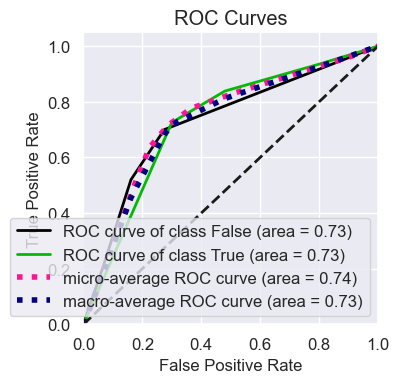

In [31]:
y_hat = tree_def.predict(X_test)
y_probas = tree_def.predict_proba(X_test)
print( sklearn.metrics.classification_report(Y_test, y_hat))

#output feature importance
feature_importance=pd.DataFrame({'Feature importance':tree_def.feature_importances_, 'features': X_train.columns})
feature_importance.sort_values(by  = 'Feature importance', ascending=False,inplace=True)
sns.set(rc={'figure.figsize':(8,4)})
fig3 = sns.barplot(feature_importance, x = 'features', y = 'Feature importance', orient = 'v', palette='crest').get_figure()
plt.xticks(rotation=45, ha='right', rotation_mode='anchor')
plt.tight_layout()
fig3.savefig(f'{basename}_feature_importance.svg')

sns.set(rc={'figure.figsize':(4,4)})
skplt.metrics.plot_confusion_matrix(Y_test, y_hat, normalize=True)
plt.tight_layout()
plt.savefig(f'{basename}_normalized_confusion.png')

skplt.metrics.plot_confusion_matrix(Y_test, y_hat)
plt.tight_layout()
plt.savefig(f'{basename}_confusion.png')

fig1 = skplt.metrics.plot_roc(Y_test, y_probas)
plt.tight_layout()
plt.savefig(f'{basename}_roc_curve.png')

### save the subsets

In [32]:
ideal_subset_selector = (df['isoflurane (%)'] < 0.75 ) & (df['state1 frequency (sexstrain zscore)']<= 0.00851079)
ideal_subset_df = df[ideal_subset_selector]
ideal_subset_df.to_csv("./dt_subset_csvs/dt_stateCPP_idealSubset_LOWISO_RARESTATE1.csv") #133+60

subset2_selector = (df['isoflurane (%)'] < 0.75 ) & (df['state1 frequency (sexstrain zscore)']> 0.00851079)
subset2_df = df[subset2_selector]
subset2_df.to_csv("./dt_subset_csvs/dt_stateCPP_subset2_LOWISO_FREQUENTSTATE1.csv") 

subset3_selector = (df['isoflurane (%)'] > 0.75 ) & (df['state4 frequency (sexstrain zscore)']<= 0.26089057)
subset3_df = df[subset3_selector]
subset3_df.to_csv("./dt_subset_csvs/dt_stateCPP_subset3_HIGHISO_RARESTATE4.csv") 

subset4_selector = (df['isoflurane (%)'] > 0.75 ) & (df['state4 frequency (sexstrain zscore)']> 0.26089057)
subset4_df = df[subset4_selector]
subset4_df.to_csv("./dt_subset_csvs/dt_stateCPP_subset3_HIGHISO_FREQUENTSTATE4.csv") 